# Basic project work

In [2]:
import pandas as pd
import numpy as np

In [3]:
train1=pd.read_table('CMAPSSData/train_FD001.txt',sep=' ',header=None)
res1=pd.read_table('CMAPSSData/RUL_FD001.txt',header=None)
test1=pd.read_table('CMAPSSData/test_FD001.txt',sep=' ',header=None)


In [8]:
#since we are artificially creating windows anyway...can we just combine train and test
train1t=train1.drop([4,5,9,11,14,16,20,22,23,24],axis=1)
test1t=test1.drop([4,5,9,11,14,16,20,22,23,24],axis=1)

In [9]:
def test_reshape_new(df,window):
    df=df.drop([26,27],axis=1)
    indexer=np.array(df.groupby([0]).count())
    for i in range(1,len(df[0].unique())):
        counter=indexer[i-1,0]
        if counter<window*2:
            df=df.drop(df[df[0]==i].index)
        else:
            continue
    x0=len(df.loc[:,0].unique())*window
    x1=window
    x2=df.shape[1]-1
    X=np.zeros((x0,x1,x2))
    y=np.zeros((x0,1))
    ticker=0
    df_scaler=MinMaxScaler()
    for i,k in enumerate(df.loc[:,0].unique()): #for each i in number of engine runs
        
        tocker=0
        run=df[df[0]==k].drop([0],axis=1) #crop out index columns and parse just this engine run
        run=np.array(df_scaler.fit_transform(run)) #we've got scaled features for engine run i
        for j in range(window):
            X[ticker]+=np.array(run[tocker:window+tocker,:]) #still putting same data in
            y[ticker]+=run.shape[0]-(window+tocker) 
            ticker+=1
            tocker+=1
    y_scaler=MinMaxScaler().fit(y)
    y=y_scaler.transform(y) #is this correct??
    return X,y

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
x_tr,y_tr=test_reshape_new(train1t,window=50)
x_te,y_te=test_reshape_new(test1t,window=50)

In [12]:
print(x_tr.shape,y_tr.shape,x_te.shape,y_te.shape)

(5000, 50, 15) (5000, 1) (3500, 50, 15) (3500, 1)


In [13]:
X=np.concatenate((x_tr,x_te))
Y=np.concatenate((y_tr,y_te))

(array([ 287., 1217., 2120., 2243., 1253.,  679.,  397.,  129.,  109.,
          66.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

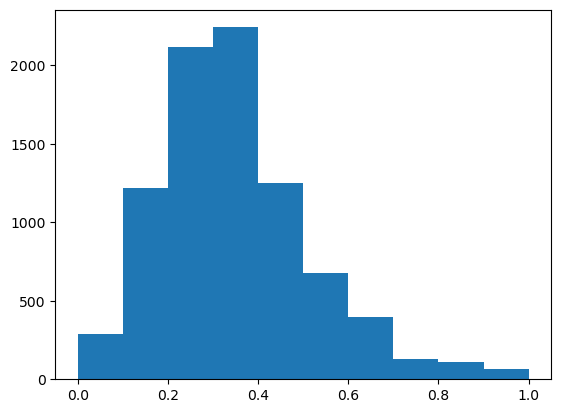

In [14]:
plt.hist(Y)

In [15]:
a=np.arange(8500)
tr_ind=np.random.choice(a,5000,replace=False)
te_ind=np.delete(a,tr_ind)

In [16]:
X_tr=X[tr_ind]
X_te=X[te_ind]
Y_tr=Y[tr_ind]
Y_te=Y[te_ind]

In [17]:
#imports for LSTM
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanSquaredError,R2Score
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import load_model

In [19]:
logytr=np.log(Y_tr+0.00000000001)

X_tr.shape

In [94]:
model_new=Sequential() #LSTM setup
model_new.add(LSTM(50,return_sequences=True,input_shape=(X_tr.shape[1],X_tr.shape[2]))) #input layer
model_new.add(LSTM(50,return_sequences=False)) #hidden layer
model_new.add(Dense(50,'relu')) #activation function
model_new.add(Dense(1,'linear')) #output layer
cp=ModelCheckpoint('modelnew/',save_best_only=True) #allows us to save best model to a file path
model_new.compile(loss='MeanSquaredError',optimizer=Adam(learning_rate=0.001),metrics=[R2Score()])
model_new.fit(X_tr_butter,Y_tr,validation_split=0.25,epochs=15,callbacks=[cp])
model_new=load_model('modelnew/')

Epoch 1/15
116/118 [============================>.] - ETA: 0s - loss: 0.0172 - r2_score: 0.3829INFO:tensorflow:Assets written to: modelnew/assets


INFO:tensorflow:Assets written to: modelnew/assets


118/118 [==============================] - 6s 41ms/step - loss: 0.0172 - r2_score: 0.3858 - val_loss: 0.0194 - val_r2_score: 0.3252
Epoch 2/15
117/118 [============================>.] - ETA: 0s - loss: 0.0091 - r2_score: 0.6772INFO:tensorflow:Assets written to: modelnew/assets


INFO:tensorflow:Assets written to: modelnew/assets


118/118 [==============================] - 4s 31ms/step - loss: 0.0090 - r2_score: 0.6769 - val_loss: 0.0073 - val_r2_score: 0.7453
Epoch 3/15
118/118 [==============================] - 2s 16ms/step - loss: 0.0069 - r2_score: 0.7548 - val_loss: 0.0111 - val_r2_score: 0.6144
Epoch 4/15
117/118 [============================>.] - ETA: 0s - loss: 0.0071 - r2_score: 0.7474INFO:tensorflow:Assets written to: modelnew/assets


INFO:tensorflow:Assets written to: modelnew/assets


118/118 [==============================] - 4s 31ms/step - loss: 0.0071 - r2_score: 0.7480 - val_loss: 0.0062 - val_r2_score: 0.7860
Epoch 5/15
118/118 [==============================] - ETA: 0s - loss: 0.0047 - r2_score: 0.8312INFO:tensorflow:Assets written to: modelnew/assets


INFO:tensorflow:Assets written to: modelnew/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.0047 - r2_score: 0.8312 - val_loss: 0.0048 - val_r2_score: 0.8320
Epoch 6/15
115/118 [============================>.] - ETA: 0s - loss: 0.0038 - r2_score: 0.8620INFO:tensorflow:Assets written to: modelnew/assets


INFO:tensorflow:Assets written to: modelnew/assets


118/118 [==============================] - 3s 29ms/step - loss: 0.0039 - r2_score: 0.8624 - val_loss: 0.0035 - val_r2_score: 0.8792
Epoch 7/15
117/118 [============================>.] - ETA: 0s - loss: 0.0028 - r2_score: 0.8989INFO:tensorflow:Assets written to: modelnew/assets


INFO:tensorflow:Assets written to: modelnew/assets


118/118 [==============================] - 3s 28ms/step - loss: 0.0028 - r2_score: 0.8989 - val_loss: 0.0032 - val_r2_score: 0.8871
Epoch 8/15
117/118 [============================>.] - ETA: 0s - loss: 0.0025 - r2_score: 0.9095INFO:tensorflow:Assets written to: modelnew/assets


INFO:tensorflow:Assets written to: modelnew/assets


118/118 [==============================] - 3s 28ms/step - loss: 0.0025 - r2_score: 0.9095 - val_loss: 0.0021 - val_r2_score: 0.9255
Epoch 9/15
118/118 [==============================] - 2s 15ms/step - loss: 0.0024 - r2_score: 0.9152 - val_loss: 0.0027 - val_r2_score: 0.9061
Epoch 10/15
118/118 [==============================] - 2s 15ms/step - loss: 0.0021 - r2_score: 0.9254 - val_loss: 0.0028 - val_r2_score: 0.9039
Epoch 11/15
115/118 [============================>.] - ETA: 0s - loss: 0.0018 - r2_score: 0.9343INFO:tensorflow:Assets written to: modelnew/assets


INFO:tensorflow:Assets written to: modelnew/assets


118/118 [==============================] - 4s 35ms/step - loss: 0.0018 - r2_score: 0.9344 - val_loss: 0.0017 - val_r2_score: 0.9420
Epoch 12/15
118/118 [==============================] - 2s 16ms/step - loss: 0.0016 - r2_score: 0.9416 - val_loss: 0.0034 - val_r2_score: 0.8828
Epoch 13/15
115/118 [============================>.] - ETA: 0s - loss: 0.0018 - r2_score: 0.9361INFO:tensorflow:Assets written to: modelnew/assets


INFO:tensorflow:Assets written to: modelnew/assets


118/118 [==============================] - 4s 32ms/step - loss: 0.0018 - r2_score: 0.9372 - val_loss: 0.0013 - val_r2_score: 0.9536
Epoch 14/15
118/118 [==============================] - 2s 19ms/step - loss: 0.0015 - r2_score: 0.9464 - val_loss: 0.0014 - val_r2_score: 0.9526
Epoch 15/15
118/118 [==============================] - 2s 17ms/step - loss: 0.0015 - r2_score: 0.9466 - val_loss: 0.0015 - val_r2_score: 0.9490


In [95]:
newpreds=model_new.predict(X_te_butter)
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
r2_score(Y_te,newpreds)

110/110 [==============================] - 1s 4ms/step


0.9519292325950675

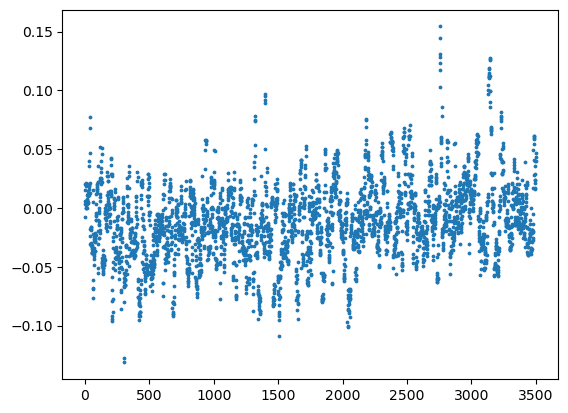

In [83]:
plt.scatter(np.arange(3500),Y_te-newpreds,s=3)

In [34]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


In [66]:
X_tr_sm=np.zeros((X_tr.shape[0],X_tr.shape[1],X_tr.shape[2]))
for i in range(X_tr.shape[0]):
    for j in range(X_tr.shape[2]):
        fitij=SimpleExpSmoothing(X_tr[i,:50,j], initialization_method="heuristic").fit(smoothing_level=0.3,optimized=False)
        X_tr_sm[i,:50,j]+=np.array(fitij.fittedvalues)

/Users/alexanderbeyer/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:1411: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/Users/alexanderbeyer/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:1418: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)


In [67]:
X_te_sm=np.zeros((X_te.shape[0],X_te.shape[1],X_te.shape[2]))
for i in range(X_te.shape[0]):
    for j in range(X_te.shape[2]):
        fitij=SimpleExpSmoothing(X_te[i,:50,j], initialization_method="heuristic").fit(smoothing_level=0.3,optimized=False)
        X_te_sm[i,:50,j]+=np.array(fitij.fittedvalues)

In [71]:
import scipy.signal
from scipy.signal import butter, filtfilt

In [102]:
X_tr_butter=np.zeros((X_tr.shape[0],X_tr.shape[1],X_tr.shape[2]))
for i in range(X_tr.shape[0]):
    for j in range(X_tr.shape[2]):
        b, a = butter(N=3, Wn=0.3, btype='low')
        X_tr_butter[i,:,j]=filtfilt(b,a,X_tr[i,:,j])

In [103]:
X_te_butter=np.zeros((X_te.shape[0],X_te.shape[1],X_te.shape[2]))
for i in range(X_te.shape[0]):
    for j in range(X_te.shape[2]):
        b, a = butter(N=3, Wn=0.3, btype='low')
        X_te_butter[i,:,j]=filtfilt(b,a,X_te[i,:,j])

In [97]:
#no appreciable improvement is made by general filtering or smoothing
#but let's see how appropriate the same filter on all features actually is

In [99]:
for i,j in enumerate(range(5)):
    print(i,j)

0 0
1 1
2 2
3 3
4 4


In [105]:
X_tr.shape

(5000, 50, 15)

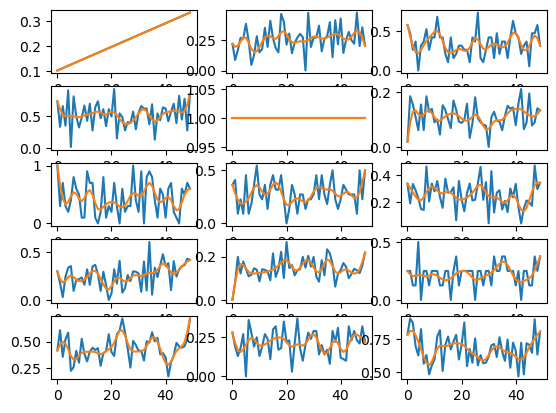

<Figure size 1500x1500 with 0 Axes>

In [112]:
fig, axs = plt.subplots(5, 3)  # 2 rows, 2 columns
#fig.tight_layout(pad=3.0)  # Add space between plots
plt.figure(figsize=(15,15))


for i in range(5):
    for j in range(3):
        k=j*5+i
        axs[i,j].plot(X_tr[0,:,k])
        axs[i,j].plot(X_tr_butter[0,:,k])

In [ ]:
#same filter looks pretty good actually
#two avenues: 1.this is worth pursuing and trying to find an algorithmic way of best filter for each (what are the metrics)
#2.no measurable difference and move on to different questions using the raw data

In [ ]:
#now, let's explore a couple of extensions.
#handling variable length windows?


In [ ]:
#we'll try padding and masking. requires rework of reshape function.

In [124]:
X_tr.shape

(5000, 50, 15)

In [167]:
len(train1t.loc[:,1])

20631

In [182]:
def test_reshape_padded(df,window,max_l,total_l):
    df=df.drop([26,27],axis=1)
    indexer=np.array(df.groupby([0]).count())

    x0=total_l
    x1=max_l
    x2=df.shape[1]-1
    X=np.zeros((x0,x1,x2))
    y=np.zeros((x0,1))
    ticker=0
    df_scaler=MinMaxScaler()
    for i,k in enumerate(df.loc[:,0].unique()): #for each i in number of engine runs
        print(i)
        tocker=0
        run=df[df[0]==k].drop([0],axis=1) #crop out index columns and parse just this engine run
        run=np.array(df_scaler.fit_transform(run)) #we've got scaled features for engine run i
        print(run.shape)
        for j in range(run.shape[0]-window): #for each timestamp j
            print(j)
            X[ticker,tocker:window+tocker,:]+=np.array(run[tocker:window+tocker,:]) #still putting same data in
            y[ticker]+=run.shape[0]-(window+tocker) 
            ticker+=1
            tocker+=1
    y_scaler=MinMaxScaler().fit(y)
    y=y_scaler.transform(y) #is this correct??
    return X,y

In [195]:
def test_reshape_padded(df,window,max_l,total_l):
    df=df.drop([26,27],axis=1)
    indexer=np.array(df.groupby([0]).count())

    x0=total_l
    x1=max_l
    x2=df.shape[1]-1
    X=[]
    y=[]
    ticker=0
    df_scaler=MinMaxScaler()
    for i,k in enumerate(df.loc[:,0].unique()): #for each i in number of engine runs
        tocker=0
        run=df[df[0]==k].drop([0],axis=1) #crop out index columns and parse just this engine run
        run=np.array(df_scaler.fit_transform(run)) #we've got scaled features for engine run i
        for j in range(run.shape[0]-window): #for each timestamp j
            X.append(np.array(run[tocker:window+tocker,:])) #still putting same data in
            y.append(run.shape[0]-(window+tocker))
            ticker+=1
            tocker+=1
    #y_scaler=MinMaxScaler().fit(y)
    #y=y_scaler.transform(y) #is this correct??
    return X,y

In [259]:
x_tr_padded,y_tr_padded=test_reshape_padded(train1t,window=100,max_l=362,total_l=20631)
x_te_padded,y_te_padded=test_reshape_padded(test1t,window=100,max_l=303,total_l=13096)

In [197]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming X is your list of input sequences
X_padded = pad_sequences(x_tr_padded, padding='post')


In [121]:
l=[]
train1tnp=np.array(train1t)
for i in np.unique(train1tnp[:,0]):
    s=train1tnp[train1tnp[:,0]==i]
    l.append(np.max(s[:,1]))

In [266]:
min(l) #longest life

31.0

In [125]:
sum(l)

20631.0

In [129]:
lt=[]
test1tnp=np.array(test1t)
for i in np.unique(test1tnp[:,0]):
    s=test1tnp[test1tnp[:,0]==i]
    lt.append(np.max(s[:,1]))

In [130]:
print(max(lt),sum(lt))

303.0 13096.0


In [260]:
x_tr_padded_np=np.array(x_tr_padded)
y_tr_padded_np=np.array(y_tr_padded)

In [261]:
XX=x_tr_padded_np.astype(np.float32)
yy=y_tr_padded_np.astype(np.float32)-1.0

In [262]:
model_pad=Sequential() #LSTM setup
model_pad.add(LSTM(50,return_sequences=True,input_shape=(x_tr_padded_np.shape[1],x_tr_padded_np.shape[2]))) #input layer
model_pad.add(LSTM(50,return_sequences=False)) #hidden layer
model_pad.add(Dense(50,'relu')) #activation function
model_pad.add(Dense(1,'linear')) #output layer
cp=ModelCheckpoint('modelnew/',save_best_only=True) #allows us to save best model to a file path
model_pad.compile(loss='MeanSquaredError',optimizer=Adam(learning_rate=0.001),metrics=[R2Score()])
model_pad.fit(XX,yy,validation_split=0.25,epochs=7,callbacks=[cp])
model_pad=load_model('modelnew/')

Epoch 1/7
248/250 [============================>.] - ETA: 0s - loss: 2767.5488 - r2_score: -0.4514INFO:tensorflow:Assets written to: modelnew/assets


INFO:tensorflow:Assets written to: modelnew/assets


250/250 [==============================] - 10s 37ms/step - loss: 2766.2261 - r2_score: -0.4486 - val_loss: 3204.7427 - val_r2_score: -0.0746
Epoch 2/7
248/250 [============================>.] - ETA: 0s - loss: 1909.2411 - r2_score: -7.6163e-04INFO:tensorflow:Assets written to: modelnew/assets


INFO:tensorflow:Assets written to: modelnew/assets


250/250 [==============================] - 9s 36ms/step - loss: 1911.0004 - r2_score: -7.5507e-04 - val_loss: 3197.8684 - val_r2_score: -0.0723
Epoch 3/7
249/250 [============================>.] - ETA: 0s - loss: 1758.2440 - r2_score: 0.0792INFO:tensorflow:Assets written to: modelnew/assets


INFO:tensorflow:Assets written to: modelnew/assets


250/250 [==============================] - 10s 38ms/step - loss: 1757.4410 - r2_score: 0.0797 - val_loss: 1792.5045 - val_r2_score: 0.3990
Epoch 4/7
248/250 [============================>.] - ETA: 0s - loss: 469.3520 - r2_score: 0.7544INFO:tensorflow:Assets written to: modelnew/assets


INFO:tensorflow:Assets written to: modelnew/assets


250/250 [==============================] - 11s 44ms/step - loss: 468.0207 - r2_score: 0.7549 - val_loss: 700.7297 - val_r2_score: 0.7650
Epoch 5/7
248/250 [============================>.] - ETA: 0s - loss: 182.9699 - r2_score: 0.9041INFO:tensorflow:Assets written to: modelnew/assets


INFO:tensorflow:Assets written to: modelnew/assets


250/250 [==============================] - 9s 37ms/step - loss: 182.4814 - r2_score: 0.9044 - val_loss: 171.0678 - val_r2_score: 0.9426
Epoch 6/7
250/250 [==============================] - 7s 30ms/step - loss: 100.3145 - r2_score: 0.9475 - val_loss: 258.3105 - val_r2_score: 0.9134
Epoch 7/7
249/250 [============================>.] - ETA: 0s - loss: 68.0562 - r2_score: 0.9644INFO:tensorflow:Assets written to: modelnew/assets


INFO:tensorflow:Assets written to: modelnew/assets


250/250 [==============================] - 9s 36ms/step - loss: 68.0178 - r2_score: 0.9644 - val_loss: 74.4546 - val_r2_score: 0.9750


In [263]:
x_te_padded_np=np.array(x_te_padded).astype(np.float32)
y_te_padded_np=np.array(y_te_padded).astype(np.float32)-1.0


In [264]:
newpreds=model_pad.predict(x_te_padded_np)
r2_score(y_te_padded_np,newpreds)

129/129 [==============================] - 1s 8ms/step


0.8253411839835146

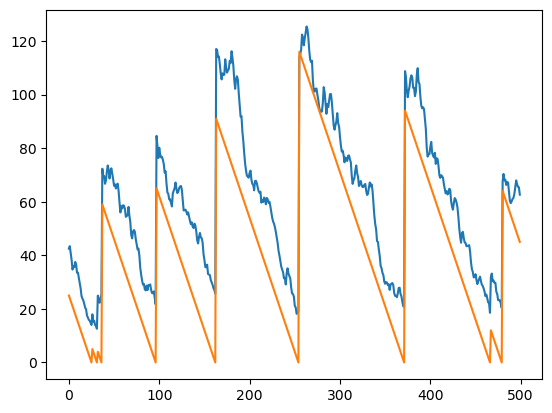

In [265]:
plt.plot(newpreds[:500])
plt.plot(y_te_padded_np[:500])